In [2]:
import os
import sys
import math
import numpy as np
import einops
import torch as t
from pathlib import Path

# Make sure exercises are in the path
chapter = r"chapter0_fundamentals"
exercises_dir = Path(f"{os.getcwd().split(chapter)[0]}/{chapter}/exercises").resolve()
section_dir = exercises_dir / "part0_prereqs"
if str(exercises_dir) not in sys.path: sys.path.append(str(exercises_dir))

from plotly_utils import imshow, line, bar
from part0_prereqs.utils import display_array_as_img
import part0_prereqs.tests as tests



In [3]:
arr = np.load(section_dir / "numbers.npy")

In [6]:
# batch, channel, height, width
arr.shape

(6, 3, 150, 150)

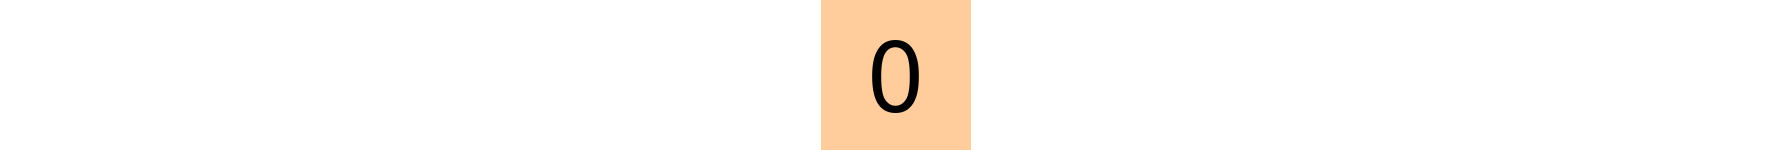

In [11]:
display_array_as_img(arr[0])

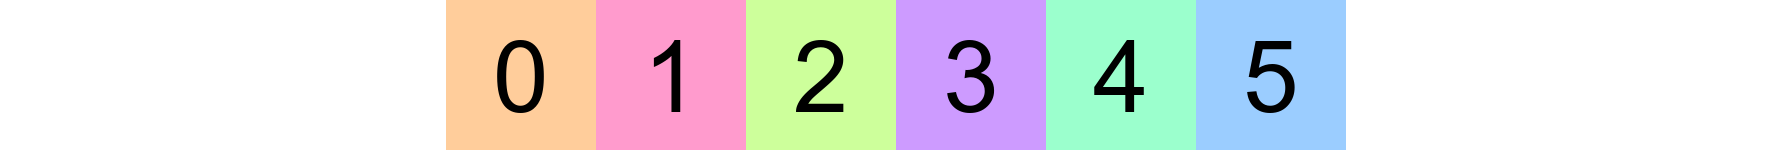

In [13]:
# Exercise 1
# Wide by batch and image width
arr1 = einops.rearrange(arr, 'b c h w -> c h (b w)')
display_array_as_img(arr1)

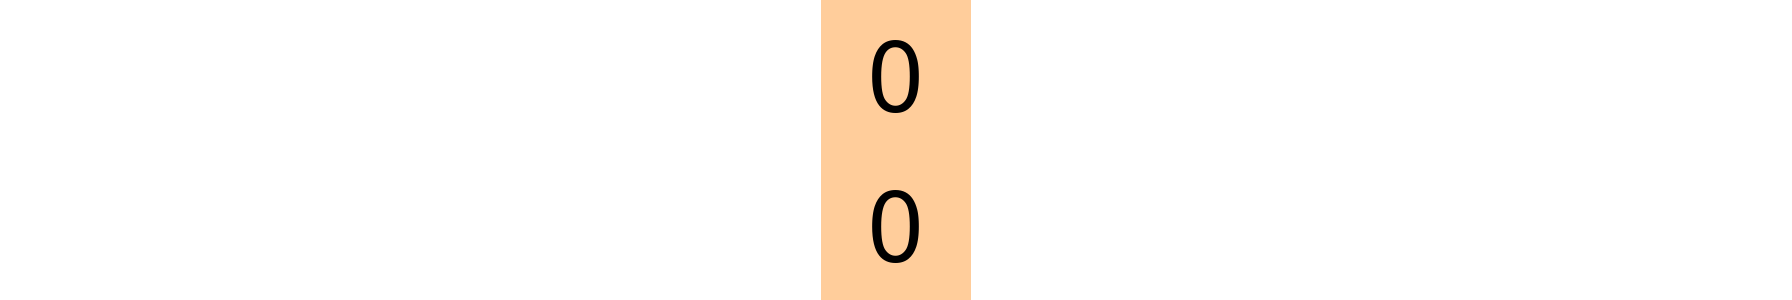

In [18]:
# Exercise 2
# Stack and duplicate first item
arr2 = einops.repeat(arr[0], 'c h w -> c (2 h) w')
display_array_as_img(arr2)

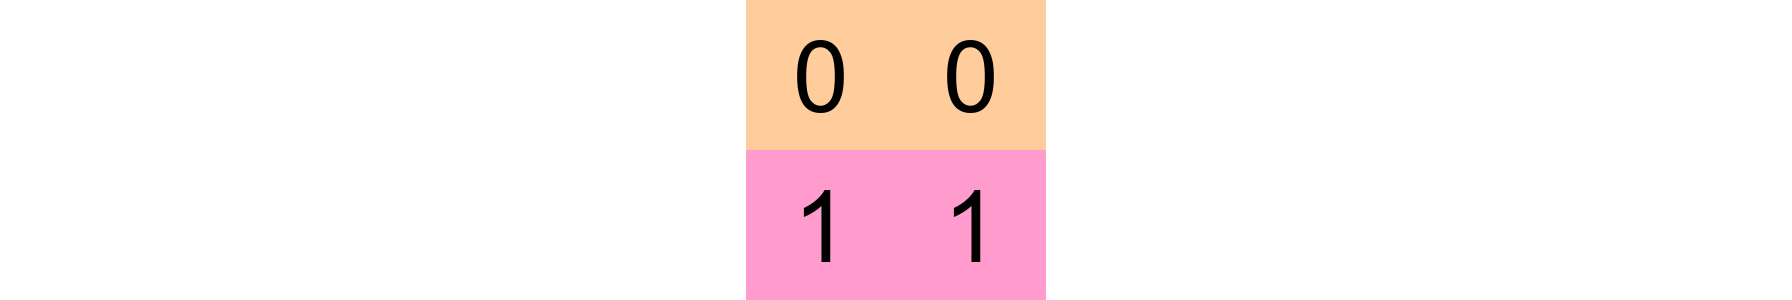

In [19]:
# Exercise 3
# Duplicate items horizontally and stack vertically
arr3 = einops.repeat(arr[:2], 'b c h w -> c (b h) (2 w)')
display_array_as_img(arr3)

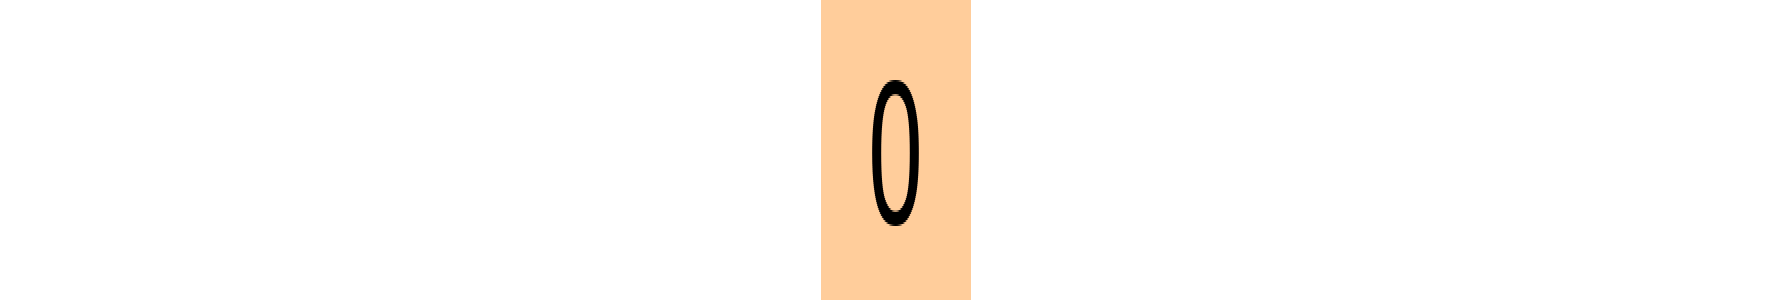

In [22]:
# Exercise 4
# stretch first image vertially
arr4 = einops.repeat(arr[0], 'c h w -> c (h 2) w')
display_array_as_img(arr4)

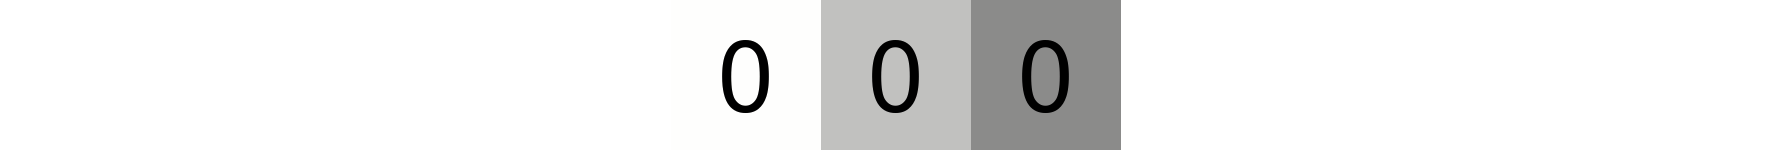

In [26]:
# Exercise 5
# Unpack color dimension
arr5 = einops.repeat(arr[0], 'c h w -> h (c w)')
display_array_as_img(arr5)

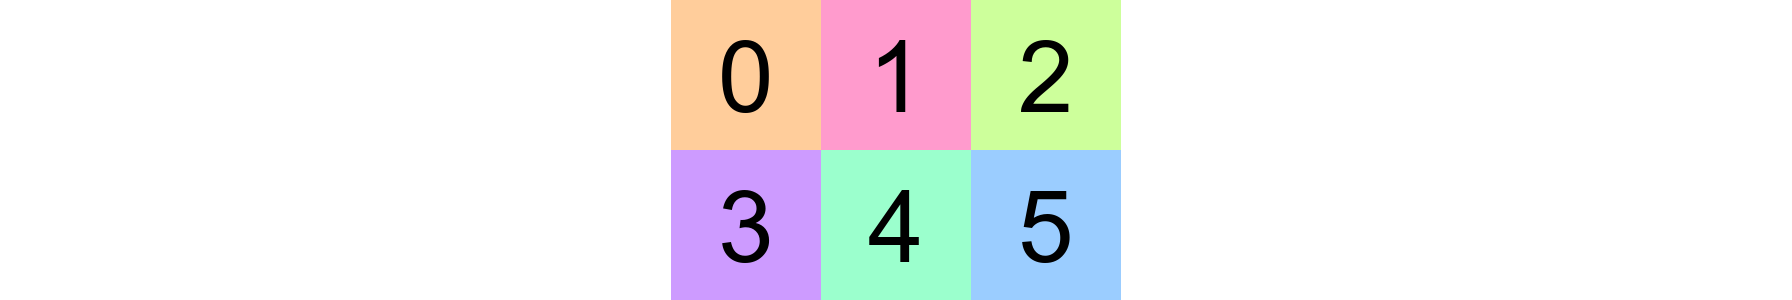

In [34]:
# Exercise 6
# 0 1 2
# 3 4 5
arr6 = einops.rearrange(arr, '(b1 b2) c h w -> c (b1 h) (b2 w)', b1=2)
display_array_as_img(arr6)

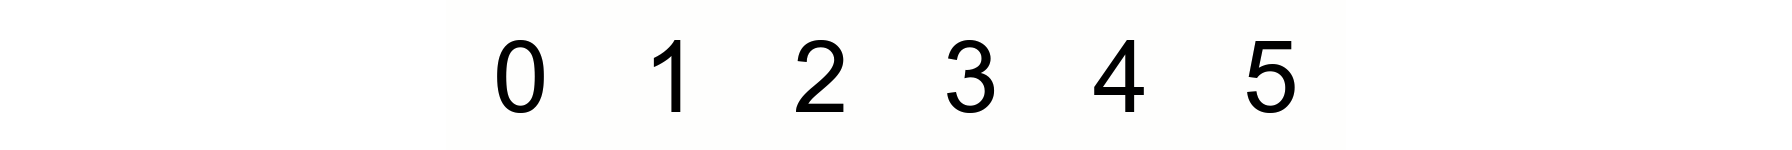

In [42]:
# Exercise 7
# max channel value 
arr7 = einops.reduce(arr, "b c h w -> h (b w)", "max")
display_array_as_img(arr7)

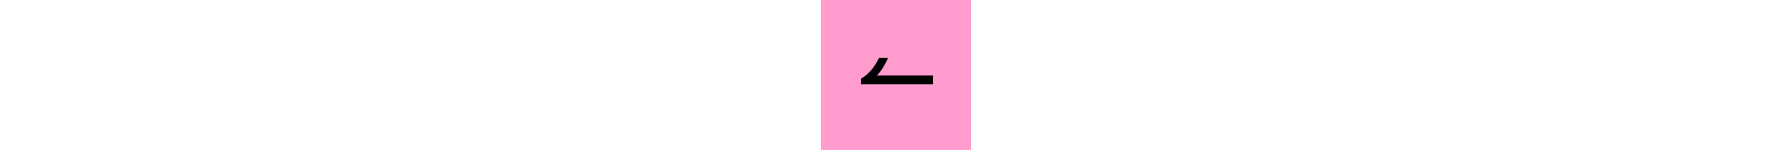

In [45]:
# Exercise 8
# Transpose 1
arr8 = einops.rearrange(arr[1], "c h w -> c w h")
display_array_as_img(arr8)

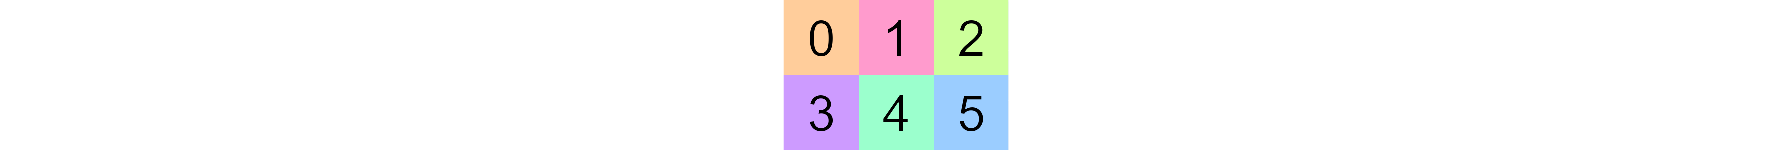

In [59]:
# Exercise 9
# 0 1 2
# 3 4 5 
# shrunk by half
arr9 = einops.reduce(arr, "(b1 b2) c (h h2) (w w2) -> c (b1 h) (b2 w)", "max", b1=2, h2=2, w2=2)
display_array_as_img(arr9)

In [60]:
def assert_all_equal(actual: t.Tensor, expected: t.Tensor) -> None:
    assert actual.shape == expected.shape, f"Shape mismatch, got: {actual.shape}"
    assert (actual == expected).all(), f"Value mismatch, got: {actual}"
    print("Passed!")

def assert_all_close(actual: t.Tensor, expected: t.Tensor, rtol=1e-05, atol=0.0001) -> None:
    assert actual.shape == expected.shape, f"Shape mismatch, got: {actual.shape}"
    assert t.allclose(actual, expected, rtol=rtol, atol=atol)
    print("Passed!")

In [64]:
def rearrange_1() -> t.Tensor:
    '''Return the following tensor using only torch.arange and einops.rearrange:

    [[3, 4],
     [5, 6],
     [7, 8]]
    '''
    return einops.rearrange(t.arange(3, 9), '(w w2) -> w w2', w=3)
    


expected = t.tensor([[3, 4], [5, 6], [7, 8]])
assert_all_equal(rearrange_1(), expected)

Passed!


In [65]:
def rearrange_2() -> t.Tensor:
    '''Return the following tensor using only torch.arange and einops.rearrange:

    [[1, 2, 3],
     [4, 5, 6]]
    '''
    return einops.rearrange(t.arange(1, 7), '(w w2) -> w w2', w=2)


assert_all_equal(rearrange_2(), t.tensor([[1, 2, 3], [4, 5, 6]]))

Passed!


In [69]:
def rearrange_3() -> t.Tensor:
    '''Return the following tensor using only torch.arange and einops.rearrange:

    [[[1], [2], [3], [4], [5], [6]]]
    '''
    return einops.rearrange(t.arange(1, 7), 'w -> 1 w 1')
    


assert_all_equal(rearrange_3(), t.tensor([[[1], [2], [3], [4], [5], [6]]]))

Passed!


In [70]:
def temperatures_average(temps: t.Tensor) -> t.Tensor:
    '''Return the average temperature for each week.

    temps: a 1D temperature containing temperatures for each day.
    Length will be a multiple of 7 and the first 7 days are for the first week, second 7 days for the second week, etc.

    You can do this with a single call to reduce.
    '''
    assert len(temps) % 7 == 0
    return einops.reduce(temps, "(w 7) -> w", 'mean')


temps = t.Tensor([71, 72, 70, 75, 71, 72, 70, 68, 65, 60, 68, 60, 55, 59, 75, 80, 85, 80, 78, 72, 83])
expected = t.tensor([71.5714, 62.1429, 79.0])
assert_all_close(temperatures_average(temps), expected)

Passed!


In [79]:
def temperatures_differences(temps: t.Tensor) -> t.Tensor:
    '''For each day, subtract the average for the week the day belongs to.

    temps: as above
    '''
    assert len(temps) % 7 == 0
    means = einops.reduce(temps, "(w 7) -> w", "mean")
    return temps - einops.repeat(means, "w -> (w 7)")
    


expected = t.tensor(
    [
        -0.5714,
        0.4286,
        -1.5714,
        3.4286,
        -0.5714,
        0.4286,
        -1.5714,
        5.8571,
        2.8571,
        -2.1429,
        5.8571,
        -2.1429,
        -7.1429,
        -3.1429,
        -4.0,
        1.0,
        6.0,
        1.0,
        -1.0,
        -7.0,
        4.0,
    ]
)


actual = temperatures_differences(temps)
assert_all_close(actual, expected)

Passed!


In [82]:
def temperatures_normalized(temps: t.Tensor) -> t.Tensor:
    '''For each day, subtract the weekly average and divide by the weekly standard deviation.

    temps: as above

    Pass torch.std to reduce.
    '''
    def broadcast(x): return einops.repeat(x, "w -> (w 7)")
    mu = einops.reduce(temps, "(w 7) -> w", "mean")
    sigma = einops.reduce(temps, "(w 7) -> w", t.std)
    return (temps - broadcast(mu)) / broadcast(sigma)


expected = t.tensor(
    [
        -0.3326,
        0.2494,
        -0.9146,
        1.9954,
        -0.3326,
        0.2494,
        -0.9146,
        1.1839,
        0.5775,
        -0.4331,
        1.1839,
        -0.4331,
        -1.4438,
        -0.6353,
        -0.8944,
        0.2236,
        1.3416,
        0.2236,
        -0.2236,
        -1.5652,
        0.8944,
    ]
)
actual = temperatures_normalized(temps)
assert_all_close(actual, expected)

Passed!


In [138]:
def sample_distribution(probs: t.Tensor, n: int) -> t.Tensor:
    '''Return n random samples from probs, where probs is a normalized probability distribution.

    probs: shape (k,) where probs[i] is the probability of event i occurring.
    n: number of random samples

    Return: shape (n,) where out[i] is an integer indicating which event was sampled.

    Use torch.rand and torch.cumsum to do this without any explicit loops.

    Note: if you think your solution is correct but the test is failing, try increasing the value of n.
    '''
    assert abs(probs.sum() - 1.0) < 0.001
    assert (probs >= 0).all()
    return (t.rand(n, 1) > probs.cumsum(0)).sum(1)
    


n = 10000000
probs = t.tensor([0.05, 0.1, 0.1, 0.2, 0.15, 0.4])
events = sample_distribution(probs, n)
freqs = t.bincount(events) / n
assert_all_close(freqs, probs, rtol=0.001, atol=0.001)

Passed!


In [144]:
def classifier_accuracy(scores: t.Tensor, true_classes: t.Tensor) -> t.Tensor:
    '''Return the fraction of inputs for which the maximum score corresponds to the true class for that input.

    scores: shape (batch, n_classes). A higher score[b, i] means that the classifier thinks class i is more likely.
    true_classes: shape (batch, ). true_classes[b] is an integer from [0...n_classes).

    Use torch.argmax.
    '''
    assert true_classes.max() < scores.shape[1]
    preds = scores.argmax(1)
    return (preds == true_classes).float().mean()

scores = t.tensor([[0.75, 0.5, 0.25], [0.1, 0.5, 0.4], [0.1, 0.7, 0.2]])
true_classes = t.tensor([0, 1, 0])
expected = 2.0 / 3.0
assert classifier_accuracy(scores, true_classes) == expected

In [147]:
def total_price_indexing(prices: t.Tensor, items: t.Tensor) -> float:
    '''Given prices for each kind of item and a tensor of items purchased, return the total price.

    prices: shape (k, ). prices[i] is the price of the ith item.
    items: shape (n, ). A 1D tensor where each value is an item index from [0..k).

    Use integer array indexing. The below document describes this for NumPy but it's the same in PyTorch:

    https://numpy.org/doc/stable/user/basics.indexing.html#integer-array-indexing
    '''
    assert items.max() < prices.shape[0]
    return prices[items].sum()


prices = t.tensor([0.5, 1, 1.5, 2, 2.5])
items = t.tensor([0, 0, 1, 1, 4, 3, 2])
assert total_price_indexing(prices, items) == 9.0

In [148]:
def gather_2d(matrix: t.Tensor, indexes: t.Tensor) -> t.Tensor:
    '''Perform a gather operation along the second dimension.

    matrix: shape (m, n)
    indexes: shape (m, k)

    Return: shape (m, k). out[i][j] = matrix[i][indexes[i][j]]

    For this problem, the test already passes and it's your job to write at least three asserts relating the arguments and the output. This is a tricky function and worth spending some time to wrap your head around its behavior.

    See: https://pytorch.org/docs/stable/generated/torch.gather.html?highlight=gather#torch.gather
    '''
    "TODO: YOUR CODE HERE"
    out = matrix.gather(1, indexes)
    "TODO: YOUR CODE HERE"
    return out


matrix = t.arange(15).view(3, 5)
indexes = t.tensor([[4], [3], [2]])
expected = t.tensor([[4], [8], [12]])
assert_all_equal(gather_2d(matrix, indexes), expected)
indexes2 = t.tensor([[2, 4], [1, 3], [0, 2]])
expected2 = t.tensor([[2, 4], [6, 8], [10, 12]])
assert_all_equal(gather_2d(matrix, indexes2), expected2)

Passed!
Passed!


In [178]:
def integer_array_indexing(matrix: t.Tensor, coords: t.Tensor) -> t.Tensor:
    '''Return the values at each coordinate using integer array indexing.

    For details on integer array indexing, see:
    https://numpy.org/doc/stable/user/basics.indexing.html#integer-array-indexing

    matrix: shape (d_0, d_1, ..., d_n)
    coords: shape (batch, n)

    Return: (batch, )
    '''
    return matrix[*coords.T]


mat_2d = t.arange(15).view(3, 5)
coords_2d = t.tensor([[0, 1], [0, 4], [1, 4]])
actual = integer_array_indexing(mat_2d, coords_2d)
assert_all_equal(actual, t.tensor([1, 4, 9]))
mat_3d = t.arange(2 * 3 * 4).view((2, 3, 4))
coords_3d = t.tensor([[0, 0, 0], [0, 1, 1], [0, 2, 2], [1, 0, 3], [1, 2, 0]])
actual = integer_array_indexing(mat_3d, coords_3d)
assert_all_equal(actual, t.tensor([0, 5, 10, 15, 20]))

Passed!
Passed!


In [199]:

def batched_logsumexp(matrix: t.Tensor) -> t.Tensor:
    '''For each row of the matrix, compute log(sum(exp(row))) in a numerically stable way.

    matrix: shape (batch, n)

    Return: (batch, ). For each i, out[i] = log(sum(exp(matrix[i]))).

    Do this without using PyTorch's logsumexp function.

    A couple useful blogs about this function:
    - https://leimao.github.io/blog/LogSumExp/
    - https://gregorygundersen.com/blog/2020/02/09/log-sum-exp/
    '''
    x_max = matrix.max(1, keepdim=True)[0]
    return (x_max + (matrix - x_max).exp().sum(1, keepdim=True).log()).squeeze()
    


matrix = t.tensor([[-1000, -1000, -1000, -1000], [1000, 1000, 1000, 1000]])
expected = t.tensor([-1000 + math.log(4), 1000 + math.log(4)])
actual = batched_logsumexp(matrix)
assert_all_close(actual, expected)
matrix2 = t.randn((10, 20))
expected2 = t.logsumexp(matrix2, dim=-1)
actual2 = batched_logsumexp(matrix2)
assert_all_close(actual2, expected2)

Passed!
Passed!


In [206]:
def batched_softmax(matrix: t.Tensor) -> t.Tensor:
    '''For each row of the matrix, compute softmax(row).

    Do this without using PyTorch's softmax function.
    Instead, use the definition of softmax: https://en.wikipedia.org/wiki/Softmax_function

    matrix: shape (batch, n)

    Return: (batch, n). For each i, out[i] should sum to 1.
    '''
    x_max = matrix.max(1, keepdim=True)[0]
    x = (matrix - x_max).exp()
    return x / x.sum(1, keepdim=True)


matrix = t.arange(1, 6).view((1, 5)).float().log()
expected = t.arange(1, 6).view((1, 5)) / 15.0
actual = batched_softmax(matrix)
assert_all_close(actual, expected)
for i in [0.12, 3.4, -5, 6.7]:
    assert_all_close(actual, batched_softmax(matrix + i))
matrix2 = t.rand((10, 20))
actual2 = batched_softmax(matrix2)
assert actual2.min() >= 0.0
assert actual2.max() <= 1.0
assert_all_equal(actual2.argsort(), matrix2.argsort())
assert_all_close(actual2.sum(dim=-1), t.ones(matrix2.shape[:-1]))

Passed!
Passed!
Passed!
Passed!
Passed!
Passed!
Passed!


In [207]:
def batched_logsoftmax(matrix: t.Tensor) -> t.Tensor:
    '''Compute log(softmax(row)) for each row of the matrix.

    matrix: shape (batch, n)

    Return: (batch, n). For each i, out[i] should sum to 1.

    Do this without using PyTorch's logsoftmax function.
    For each row, subtract the maximum first to avoid overflow if the row contains large values.
    '''
    return batched_softmax(matrix).log()


matrix = t.arange(1, 6).view((1, 5)).float()
start = 1000
matrix2 = t.arange(start + 1, start + 6).view((1, 5)).float()
actual = batched_logsoftmax(matrix2)
expected = t.tensor([[-4.4519, -3.4519, -2.4519, -1.4519, -0.4519]])
assert_all_close(actual, expected)

Passed!


In [218]:
def batched_cross_entropy_loss(logits: t.Tensor, true_labels: t.Tensor) -> t.Tensor:
    '''Compute the cross entropy loss for each example in the batch.

    logits: shape (batch, classes). logits[i][j] is the unnormalized prediction for example i and class j.
    true_labels: shape (batch, ). true_labels[i] is an integer index representing the true class for example i.

    Return: shape (batch, ). out[i] is the loss for example i.

    Hint: convert the logits to log-probabilities using your batched_logsoftmax from above.
    Then the loss for an example is just the negative of the log-probability that the model assigned to the true class. Use torch.gather to perform the indexing.
    '''
    return (-batched_logsoftmax(logits)).gather(1, true_labels.view(-1, 1)).squeeze()
    
    


logits = t.tensor([[float("-inf"), float("-inf"), 0], [1 / 3, 1 / 3, 1 / 3], [float("-inf"), 0, 0]])
true_labels = t.tensor([2, 0, 0])
expected = t.tensor([0.0, math.log(3), float("inf")])
actual = batched_cross_entropy_loss(logits, true_labels)
assert_all_close(actual, expected)

Passed!


In [219]:
def collect_rows(matrix: t.Tensor, row_indexes: t.Tensor) -> t.Tensor:
    '''Return a 2D matrix whose rows are taken from the input matrix in order according to row_indexes.

    matrix: shape (m, n)
    row_indexes: shape (k,). Each value is an integer in [0..m).

    Return: shape (k, n). out[i] is matrix[row_indexes[i]].
    '''
    assert row_indexes.max() < matrix.shape[0]
    return matrix[row_indexes]


matrix = t.arange(15).view((5, 3))
row_indexes = t.tensor([0, 2, 1, 0])
actual = collect_rows(matrix, row_indexes)
expected = t.tensor([[0, 1, 2], [6, 7, 8], [3, 4, 5], [0, 1, 2]])
assert_all_equal(actual, expected)

Passed!


In [220]:
def collect_columns(matrix: t.Tensor, column_indexes: t.Tensor) -> t.Tensor:
    '''Return a 2D matrix whose columns are taken from the input matrix in order according to column_indexes.

    matrix: shape (m, n)
    column_indexes: shape (k,). Each value is an integer in [0..n).

    Return: shape (m, k). out[:, i] is matrix[:, column_indexes[i]].
    '''
    assert column_indexes.max() < matrix.shape[1]
    return matrix[:, column_indexes]


matrix = t.arange(15).view((5, 3))
column_indexes = t.tensor([0, 2, 1, 0])
actual = collect_columns(matrix, column_indexes)
expected = t.tensor([[0, 2, 1, 0], [3, 5, 4, 3], [6, 8, 7, 6], [9, 11, 10, 9], [12, 14, 13, 12]])
assert_all_equal(actual, expected)

Passed!


In [233]:
def einsum_trace(mat: np.ndarray):
    '''
    Returns the same as `np.trace`.
    '''
    return einops.einsum(mat, "i i -> ")

def einsum_mv(mat: np.ndarray, vec: np.ndarray):
    '''
    Returns the same as `np.matmul`, when `mat` is a 2D array and `vec` is 1D.
    '''
    return einops.einsum(mat, vec, "i j, j -> i")
    
def einsum_mm(mat1: np.ndarray, mat2: np.ndarray):
    '''
    Returns the same as `np.matmul`, when `mat1` and `mat2` are both 2D arrays.
    '''
    return einops.einsum(mat1, mat2, "i k, k j -> i j")

def einsum_inner(vec1: np.ndarray, vec2: np.ndarray):
    '''
    Returns the same as `np.inner`.
    '''
    return einops.einsum(vec1, vec2, "i, i -> ")

def einsum_outer(vec1: np.ndarray, vec2: np.ndarray):
    '''
    Returns the same as `np.outer`.
    '''
    return einops.einsum(vec1, vec2, "i, j -> i j")


tests.test_einsum_trace(einsum_trace)
tests.test_einsum_mv(einsum_mv)
tests.test_einsum_mm(einsum_mm)
tests.test_einsum_inner(einsum_inner)
# tests.test_einsum_outer(einsum_outer)

All tests in `test_einsum_trace` passed!
All tests in `test_einsum_mv` passed!
All tests in `test_einsum_mm` passed!
All tests in `test_einsum_inner` passed!
